In [36]:
import numpy as np
import h5py
import matplotlib.colors as colors
import scipy as sp 
import matplotlib.pyplot as plt
import scipy.constants as cons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from openpmd_viewer import ParticleTracker
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

def add_colorbar(im, width = None, pad = None, **kwargs):
    l, b, w, h = im.axes.get_position().bounds  # get boundaries
    width = width or 0.05*w                    # width of colorbar
    pad = pad or width                         # pad between im and cbar
    fig = im.axes.figure                       # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h]) # define cbar axes
    return fig.colorbar(im,cax=cax,**kwargs)
#######################Lasy libraries#####################

pi = cons.pi
clight = cons.speed_of_light
epsilon_0 = cons.epsilon_0
me = cons.electron_mass
qe = cons.elementary_charge

# Solving Differential equations

Lets take a look at a first order differential equation: 

$$ \frac{\mathrm{d}y}{\mathrm{d}t} = f(t,y) $$


from the definition of the derivative we know  $ \frac{\mathrm{d}y}{\mathrm{d}t} = \frac{y(t+h)-y(t)}{h}$

Solving for the future value  $ y(t+h) = \frac{\mathrm{d}y}{\mathrm{d}t}h + y(t)$.

Therefore, we can repetitively iterate the propagation: 

From the value $ y_n $ at step $ n $, corresponding to the time $ t $, we can calculate the value $ y_{n+1} $ at step $ (n+1) $, corresponding to the time $ (t+h) $:

$y_{n+1} = y_n + \frac{\mathrm{d}y}{\mathrm{d}t}h $ 

which is 

$ y_{n+1} = y_n + f(t,y_n) h $ (Eq 1)

We can do this in our sleep, lets look at second order differential equations since they appear in physics. To do this we will need to play a trick since we can only solve first order differential equations via this method. 

Lets start by looking at a second order DE, you can see that it depends on time $t$, say position $y(t)$ and velocity $y'(t)$

$$y''(t) = f(t, y(t), y'(t))$$

Here is the trick, introduce two new variables:

$$g_0(t) = y(t)$$
$$g_1(t) = y'(t)$$

If we now differentiate we get 

$$g_0'(t) = y'(t) = g_1 (t)$$
$$g_1'(t) = y''(t) = f(t, y(t), y'(t)) $$

Now we can put this in the form of Eq1

$\frac{d g_0}{d t} = \frac{g_0(t + h) - g_0(t)}{h}$

Solving for $g_0(t + h)$ future value 

$g_0(t + h) \approx \frac{d g_0}{d t} h + g_0(t)$ which is 

To find the future postion value you need the previous velocity and position

$y(t + h) = y'(t) h + y(t)$

We do the same for the other equation

$g_1(t + h) \approx \frac{d g_1}{d t} h + g_1(t)$ which is 

$y'(t + h) = y''(t) h + y'(t) =   f(t, y(t), y'(t)) h + y'(t) $

To solve for the future velocity you need the previous velcoity and value of f or accleration. This is the Forward Euler method of solvibg second order DE. 

Your HW will be to implment this method. You will notice that this method is less accurate than the methods we will use in this Notebook, but its important to understand how simple cases work. 

# Setting up the equations of motion for a particle in an electromagnetic field

In [13]:
# Equations of motion 
def eqs_of_motion(t, X, E, B):
    """Return the time derivatives"""
    #defining variables to be inputted
    x, vx, y, vy, z, vz = X
    Ex, Ey, Ez = E
    Bx, By, Bz = B
    #define constant: charge q over mass
    qom = qe / me
    #defining diffeqs
    ax = qom * (Ex + (vx * Bz - vz*By))
    ay = qom * (Ey - ( vx * Bz - vz*Bx))
    az = qom * (Ez + ( vx * By - vy*Bx))
    #returning values
    return vx, ax, vy, ay, vz, az


#initial conditions
x0 = 0
y0 = 0
z0 = 0
vx0 = 0
vy0 = 1
vz0 = 0
E = (10,0,0)
B = (1,0,0)

#put all cartesian initial conditions together
X0 = (x0, vx0, y0, vy0, z0,vz0)

# Setup a time grid on which to carry out the integration.
dt = 10**-12
N = 1000
tmax = (N-1)*dt
t_eval = np.linspace(0, tmax, N)
t_span = (0,tmax)

# takes in the time derivatives, Interval of integration,Initial state,Integration method,Times at which to store the computed solution,Additional arguments
solution_eq_mo = solve_ivp(eqs_of_motion,t_span,X0, method= 'RK45',t_eval=t_eval,args=(E, B) )

# Getting the positions and velocities of the particle 

In [14]:
# Get positions and velocities
x_pos = solution_eq_mo.y[0]
vx = solution_eq_mo.y[1]
y_pos = solution_eq_mo.y[2]
vy = solution_eq_mo.y[3]
z_pos = solution_eq_mo.y[4]
vz = solution_eq_mo.y[5]

# Lets plot the particle trjajectory

### what do you expect to see? 

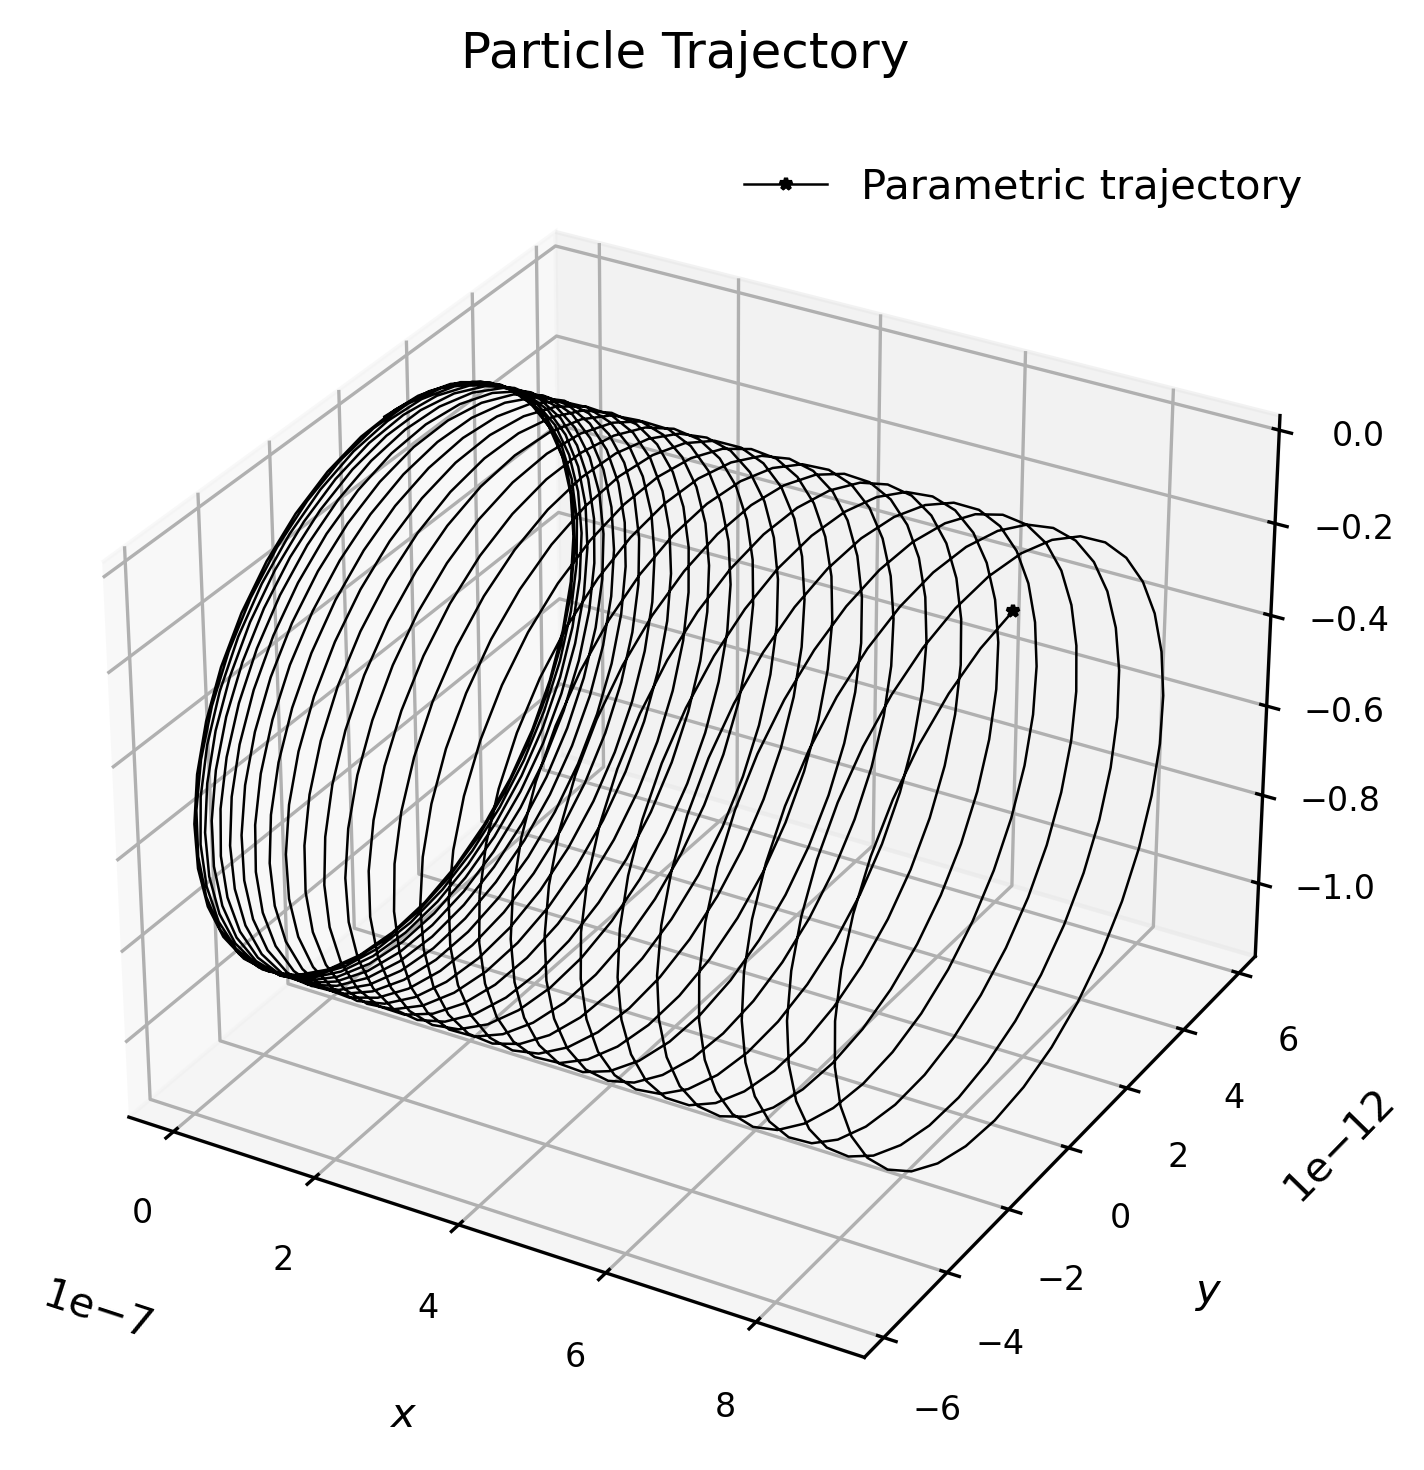

In [15]:
fig_width = 5
fig_height = 5
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot(
    x_pos, y_pos, z_pos,
    '*-',
    color='black',
    linewidth=0.6,
    markersize=3,
    markevery=[-1],
    label='Parametric trajectory'
)

# ---- Labels ----
ax.set_xlabel(r'$x$', labelpad=10)
ax.set_ylabel(r'$y$', labelpad=10)
ax.set_zlabel(r'$z$', labelpad=10)

# ---- Title ----
ax.set_title('Particle Trajectory', pad=15)

# ---- Aspect ratio (important for visibility) ----


# ---- Legend ----
ax.legend(loc='best', frameon=False)

# ---- Improve readability ----
ax.grid(True)
ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()



# What if we had something much more complicated with a nonuniform magnetic or electric field ? 
### Lets use warpx to look at the magnetic mirror, here you can think of the magnetic field as two magnetic dipoles 

https://en.wikipedia.org/wiki/Magnetic_dipole 

### HW: can you write a python function to show the magnetic dipole ?

$$\vec{B}(\vec{r}) = \frac{\mu_0}{4 \pi} [\frac{3 \vec{r} (\vec{m} \cdot \vec{r} )}{r^5} - \frac{\vec{m}}{r^3}]$$


# Magnetic field 

In [17]:
# Path to data
path_fdtd ='/Users/victorflores/warpx_env/WarpX/Single_Particle_Motion/Magnetic_Mirror/diags/diag1'
# Use openpmd to gather the data 
data= OpenPMDTimeSeries("{}".format(path_fdtd),backend="h5py")

# Look at the iterations 
iterations = data.iterations
it = iterations[-1]

# Gathering magnetic field data
Bx, info = data.get_field('B', coord='x', iteration=it)
By, info = data.get_field('B', coord='y', iteration=it)
Bz, info = data.get_field('B', coord='z', iteration=it)

In [18]:
# Shape of the data 
np.shape(Bx)

(40, 40, 40)

# Visualizing the magnetic field

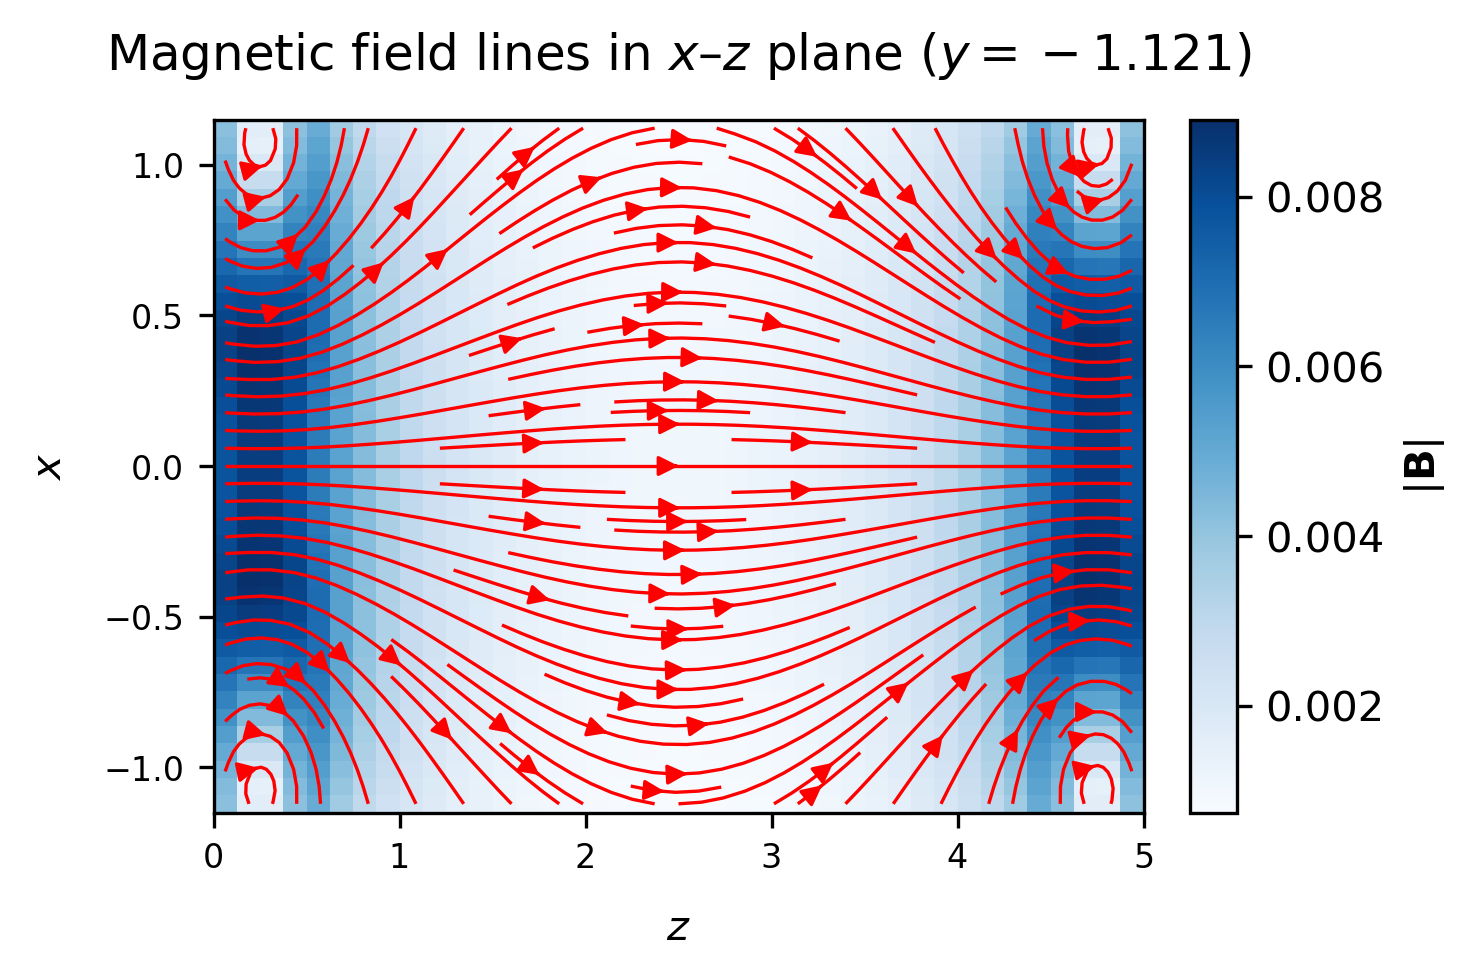

In [28]:
# Getting the spatial coordinate information
x = info.x
y = info.y
z = info.z

# choose slice along y
iy = 0  # or any index you want

# Lets slice the field along y axis
Bx_xz = Bx[:, iy, :]   
Bz_xz = Bz[:, iy, :]
By_xz = By[:, iy, :]

# get field magnitude 
Bmag_xz = np.sqrt(Bx_xz**2 + Bz_xz**2 + By_xz**2)

# Plot
fig_width = 4
fig_height = 3
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

ax = fig.add_subplot(1, 1, 1)
# ---- Background magnitude ----
pcm = ax.pcolormesh(
    z, x,
    Bmag_xz.T,
    shading="auto",
    cmap="Blues"
)
cbar = add_colorbar(pcm)
cbar.set_label(r"$|\mathbf{B}|$", fontsize=10)
# ---- Streamlines ----
ax.streamplot(
    z, x,
    Bz_xz.T, Bx_xz.T,
    color="red",
    density=1.3,
    linewidth=0.8,
    arrowsize=1
)
# ---- Labels ----
ax.set_xlabel(r"$z$", labelpad=8)
ax.set_ylabel(r"$x$", labelpad=8)
# ---- Title ----
ax.set_title(rf"Magnetic field lines in $x$–$z$ plane ($y = {y[iy]:.3f}$)",pad=12)
# ---- Improve readability ----
ax.tick_params(labelsize=8)

plt.show()



# Visualizing the particle trajectory

In [ ]:
# we are going to select particles in a certain position regime and track them over the entire simulation
pt = ParticleTracker( data, iteration=iterations[-1], select={'z':[0,3.5], 'x':[-0.5, 0.5],'y':[-0.5, 0.5]}, species='protons', preserve_particle_index=True)
N_particles = pt.N_selected
N_iterations = len(iterations)

x_trajectories =  np.empty( ( N_iterations, N_particles ) )
y_trajectories =  np.empty( ( N_iterations, N_particles ) )
z_trajectories = np.empty( ( N_iterations, N_particles ) )
ux_trajectories =  np.empty( ( N_iterations, N_particles ) )
uy_trajectories =  np.empty( ( N_iterations, N_particles ) )
uz_trajectories = np.empty( ( N_iterations, N_particles ) )
for i, it in enumerate( iterations ):
    x,ux,y,uy,z,uz = data.get_particle( ['x','ux','y','uy','z','uz'], select=pt, iteration=it, species='protons' )
    x_trajectories[i, :] = x[:]
    y_trajectories[i, :] = y[:]
    z_trajectories[i, :] = z[:]
    ux_trajectories[i, :] = ux[:]
    uy_trajectories[i, :] = uy[:]
    uz_trajectories[i, :] = uz[:]

/Users/victorflores/opt/anaconda3/envs/warpx_env/lib/python3.12/site-packages/openpmd_viewer/openpmd_timeseries/numba_wrapper.py:24: UserWarning: 
One of the functions called by openPMD-viewer (extract_indices)
could have been faster if `numba` had been installed.
Please consider installing `numba` (e.g. `pip install numba`)
  warnings.warn(


In [30]:
# Look at the shape of the trajectories
np.shape(x_trajectories)

(501, 384)

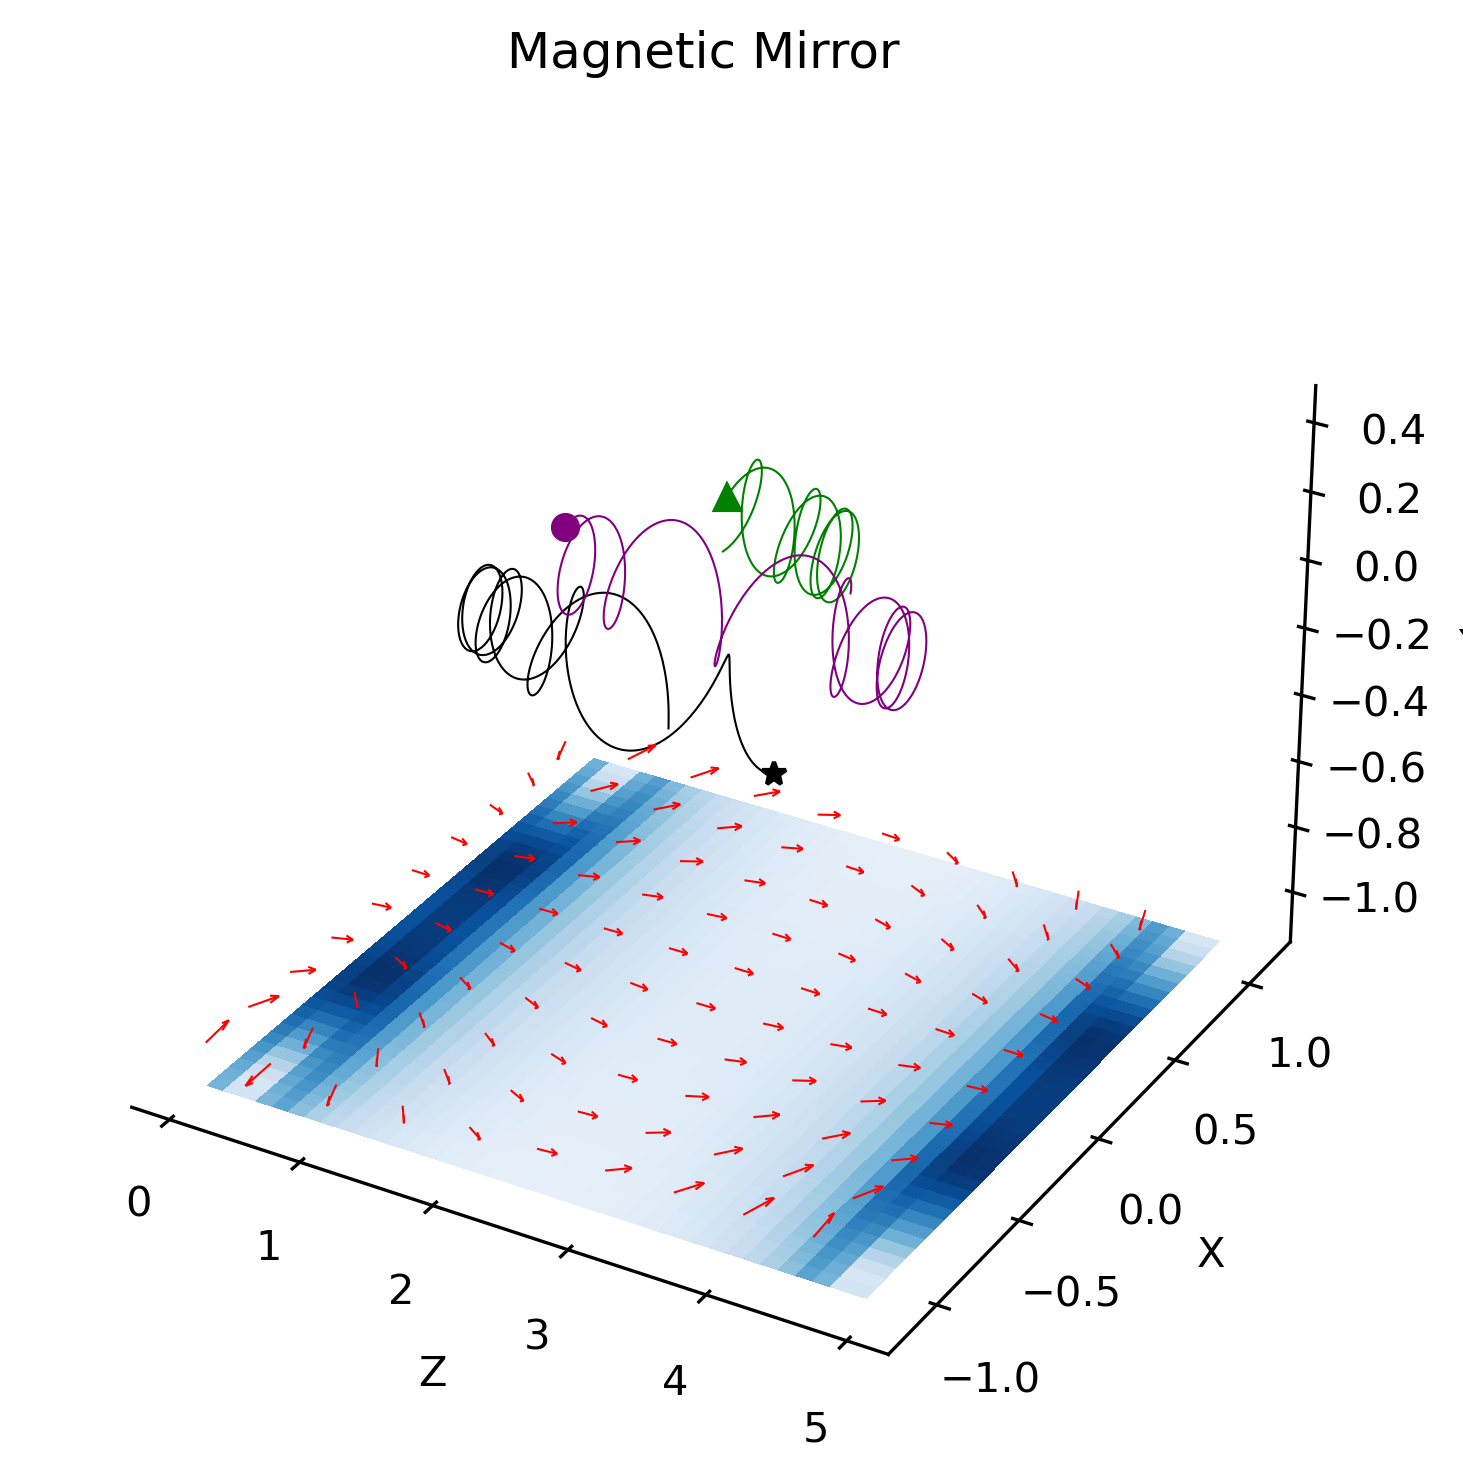

In [31]:
# gather spatial coordinates
x = info.x
y = info.y
z = info.z
# choose y-slice
iy = 0
y0 = y[iy]

Bx_xz = Bx[:, iy, :]
By_xz = By[:, iy, :]
Bz_xz = Bz[:, iy, :]

Bmag_xz = np.sqrt(Bx_xz**2 + By_xz**2 + Bz_xz**2)

# create 3D coordinates
Z, X = np.meshgrid(z, x, indexing='ij')
Y = np.full_like(Z, y0)

# downsample for quiver (so it's not too crowded)
step = 4
Xq = X[::step, ::step]
Zq = Z[::step, ::step]
Yq = Y[::step, ::step]
Bxq = Bx_xz[::step, ::step]
Bzq = Bz_xz[::step, ::step]

# ---------------------------
# 3D plot
# ---------------------------
# create 2 subplots stacked vertically
fig_width = 10
fig_height = 5
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
# first subplot: 3D surface
ax = fig.add_subplot(1, 1, 1, projection='3d')
# Surface colored by |B|
tt0 = 250
tt1 = 50
tt3 = 31
norm = Bmag_xz / np.max(Bmag_xz)
facecolors = plt.cm.Blues(norm)
ax.plot_surface(
    Z, X, Y,
    facecolors=facecolors,
    rstride=1,
    cstride=1,
    linewidth=0,
    antialiased=False,
    shade=False
)
ax.plot(z_trajectories[:,tt0], y_trajectories[:,tt0],x_trajectories[:,tt0],'*-', color='black',label='parametric curve',markevery=[-1],linewidth=0.5)
ax.plot(z_trajectories[:,tt1], y_trajectories[:,tt1],x_trajectories[:,tt1],'^-', color='green',label='parametric curve',markevery=[-1],linewidth=0.5)
ax.plot(z_trajectories[:,tt3], y_trajectories[:,tt3],x_trajectories[:,tt3],'o-', color='purple',label='parametric curve',markevery=[-1],linewidth=0.5)
# quiver for field vectors
ax.quiver(Zq, Xq, Yq+0.13, Bzq, Bxq, 0, length=0.14, color='red', normalize=True,linewidth=0.5)
# labels
ax.set_xlabel("Z")
ax.set_ylabel("X")
ax.set_zlabel("Y")
ax.set_title(f"Magnetic Mirror")
ax.view_init(elev=30, azim=-60)
ax.grid(False)  # hide gridlines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')  # optional: hide edges
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.tight_layout()
plt.show()



# Its a little hard to see whats going on in 3D lets make a 2D plot with trajectories

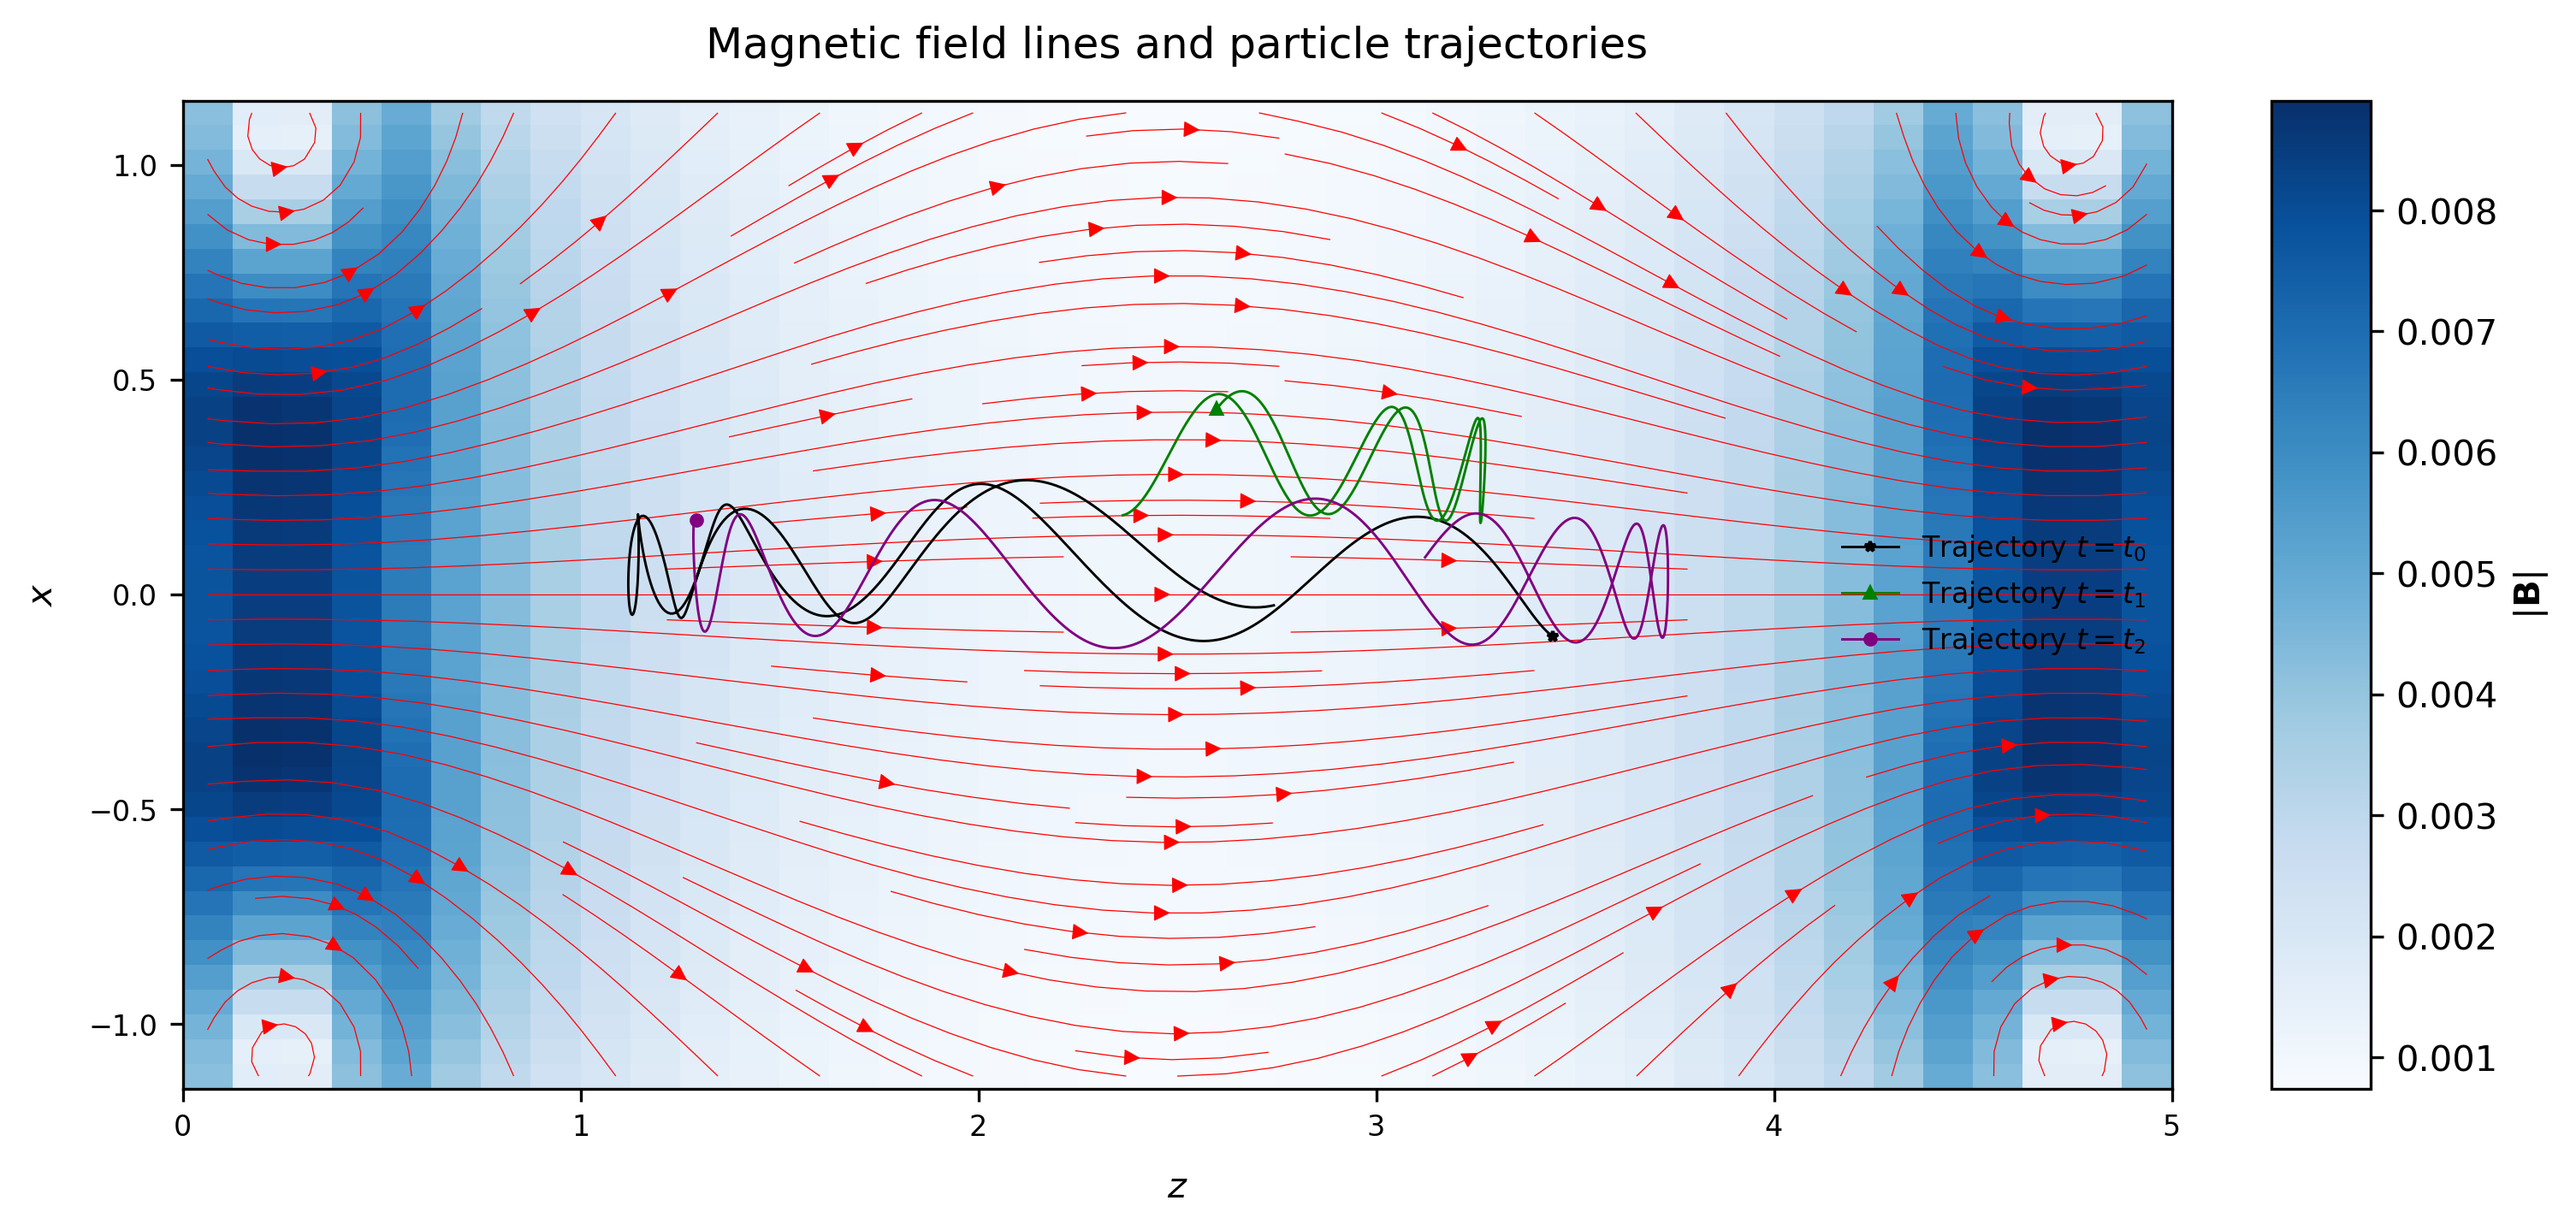

In [33]:
fig_width = 10
fig_height = 5
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
# ---- Background magnetic-field magnitude ----
pcm = ax.pcolormesh(
    z, x,
    Bmag_xz.T,
    shading="auto",
    cmap="Blues"
)

cbar = add_colorbar(pcm)
cbar.set_label(r"$|\mathbf{B}|$", fontsize=10)
# ---- Magnetic field lines ----
ax.streamplot(
    z, x,
    Bz_xz.T, Bx_xz.T,
    color="red",
    density=1.3,
    linewidth=0.3,
    arrowsize=1
)
# ---- Particle trajectories ----
ax.plot(
    z_trajectories[:, tt0],
    x_trajectories[:, tt0],
    '*-',
    color='black',
    linewidth=0.7,
    markersize=3,
    markevery=[-1],
    label=rf"Trajectory $t=t_0$"
)
ax.plot(
    z_trajectories[:, tt1],
    x_trajectories[:, tt1],
    '^-',
    color='green',
    linewidth=0.7,
    markersize=3,
    markevery=[-1],
    label=rf"Trajectory $t=t_1$"
)
ax.plot(
    z_trajectories[:, tt3],
    x_trajectories[:, tt3],
    'o-',
    color='purple',
    linewidth=0.7,
    markersize=3,
    markevery=[-1],
    label=rf"Trajectory $t=t_2$"
)
# ---- Labels ----
ax.set_xlabel(r"$z$", labelpad=8)
ax.set_ylabel(r"$x$", labelpad=8)

# ---- Title ----
ax.set_title("Magnetic field lines and particle trajectories", pad=12)
# ---- Legend ----
ax.legend(frameon=False, fontsize=8, loc="best")
# ---- Readability ----
ax.tick_params(labelsize=8)

plt.show()
